<a href="https://colab.research.google.com/github/quiquedalfo/Proyecto-DH-CDI61185-Dalfo/blob/main/VentasZapatos_Dalfo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Ventas de zapatos 2023**

Este dataset pertenece a mi trabajo. Se trata de las ventas de zapatos en el año 2023.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns


In [ ]:
url = 'https://raw.githubusercontent.com/quiquedalfo/Proyecto-DH-CDI61185-Dalfo/main/2023.csv'
df = pd.read_csv(url, sep=';')
df.head()

,fnum,fobs,ft101,ffch,fven,fturno,fart,fcolo,ftall,fcant,...,Temp,UFL,Altura Caña,Altura Taco,Altura Punta,Pendiente,Rango,Estacion,Nombre,Color
0,113001499,FECHA: 01/01/23,MDP,1/1/2023,1397,2,388395,38839,5,1,...,VER22,11/11/2021,0,35,30,5,baja,1VERANO,Dustland,Blanco
1,113001500,FECHA: 01/01/23,MDP,1/1/2023,1397,2,388409,38840,9,1,...,VER22,28/10/2021,0,43,31,10,baja,1VERANO,Nearness,Negro
2,113001501,FECHA: 01/01/23,MDP,1/1/2023,1397,2,397085,39708,5,1,...,VER23,16/11/2022,0,98,71,25,alta,1VERANO,Muse,Negro
3,113001502,FECHA: 01/01/23,MDP,1/1/2023,1335,2,378819,37881,9,-1,...,VER21SS,1/11/2020,0,73,8,0,0,1VERANO,Glory,Negro
4,113001502,FECHA: 01/01/23,MDP,1/1/2023,1335,2,388948,38894,8,1,...,VER22,10/1/2022,0,0,3,0,0,1VERANO,Upside,Negro


Preguntas de interes:

*   Que familia de zapatos se venden mas?
*   Identificar top familas de verano y de invierno segun ventas.
*   Segun el top 25 de productos vendidos de la mejor familia, existe cierto patron en las cualidades de los productos?


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113392 entries, 0 to 113391
Data columns (total 26 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   fnum          113392 non-null  int64 
 1   fobs          113392 non-null  object
 2   ft101         113392 non-null  object
 3   ffch          113392 non-null  object
 4   fven          113392 non-null  object
 5   fturno        113392 non-null  int64 
 6   fart          113392 non-null  int64 
 7   fcolo         113392 non-null  int64 
 8   ftall         113392 non-null  int64 
 9   fcant         113392 non-null  int64 
 10  fprun         113392 non-null  object
 11  fneto         113392 non-null  object
 12  fhora         113392 non-null  object
 13  Familia       113235 non-null  object
 14  Subfamilia    113235 non-null  object
 15  Tunif         113235 non-null  object
 16  Temp          113235 non-null  object
 17  UFL           113392 non-null  object
 18  Altura Caña   113392 non

In [ ]:
columns_seleccionadas = ['ffch','fcolo', 'ftall', 'fcant','Altura Taco','Altura Punta','Familia','Subfamilia','Tunif','Altura Caña','Nombre','Color']
df = df.rename(columns={'ffch': 'Fecha', 'articulo': 'Articulo', 'talle': 'Talle','fcant': 'Cantidad'})
df = df.fillna(0)
df.head()

,fnum,fobs,ft101,Fecha,fven,fturno,fart,fcolo,ftall,Cantidad,...,Temp,UFL,Altura Caña,Altura Taco,Altura Punta,Pendiente,Rango,Estacion,Nombre,Color
0,113001499,FECHA: 01/01/23,MDP,1/1/2023,1397,2,388395,38839,5,1,...,VER22,11/11/2021,0,35,30,5,baja,1VERANO,Dustland,Blanco
1,113001500,FECHA: 01/01/23,MDP,1/1/2023,1397,2,388409,38840,9,1,...,VER22,28/10/2021,0,43,31,10,baja,1VERANO,Nearness,Negro
2,113001501,FECHA: 01/01/23,MDP,1/1/2023,1397,2,397085,39708,5,1,...,VER23,16/11/2022,0,98,71,25,alta,1VERANO,Muse,Negro
3,113001502,FECHA: 01/01/23,MDP,1/1/2023,1335,2,378819,37881,9,-1,...,VER21SS,1/11/2020,0,73,8,0,0,1VERANO,Glory,Negro
4,113001502,FECHA: 01/01/23,MDP,1/1/2023,1335,2,388948,38894,8,1,...,VER22,10/1/2022,0,0,3,0,0,1VERANO,Upside,Negro


In [ ]:
for column in df.columns:
  if df[column].dtype == 'object':
    df[column] = df[column].str.upper().str.strip()

In [ ]:
print(df['Familia'].unique())

['GOMA BAJA' 'GOMA ALTA' 'SUELA SANDALIA' 'TACO Y PLATAFORMA' 'GOMA MEDIA'
 'CHATAS' 'TEXANAS' 'BASES' 'LOAFERS' 'MOCASINES' 'SNEAKERS' 'G BOTA'
 'BORCEGOS' 'STILETTOS' 'SUELA BOTA' 'G-TACO Y PLATAFORMA' 'BALLERINAS'
 nan 'VINTAGE' '0' 'SUELA BORCEGO' 'MADERAS' 'ZVARIOS' 'SUELA ZAPATO'
 'ESTRIBO']


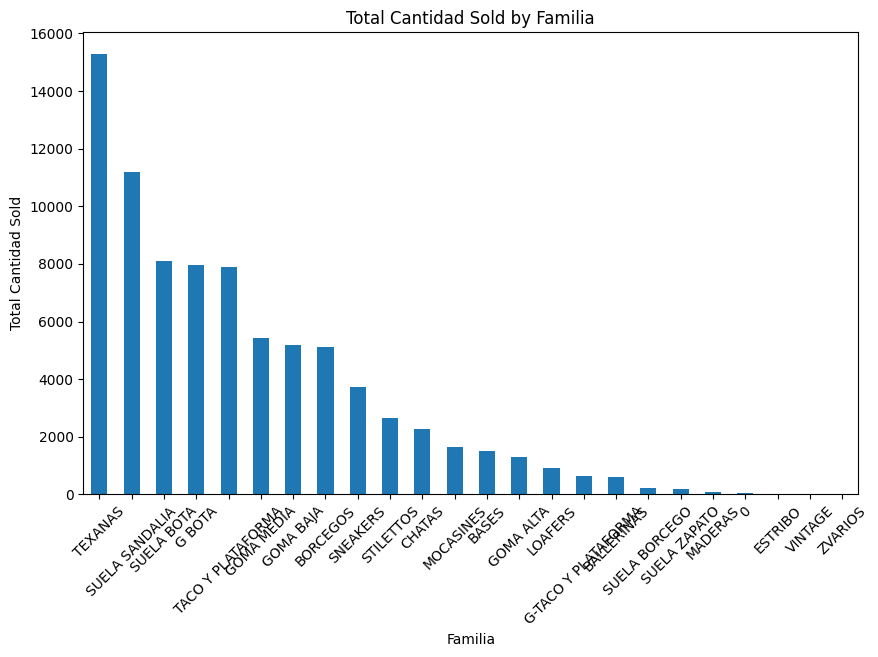

In [ ]:
# Calculate total 'Cantidad' for each 'Familia'
familia_cantidad = df.groupby('Familia')['Cantidad'].sum().sort_values(ascending=False)

# Create the plot
ax = familia_cantidad.plot(kind='bar', figsize=(10, 6))
plt.title('Total Cantidad Sold by Familia')
plt.xlabel('Familia')
plt.ylabel('Total Cantidad Sold')
plt.xticks(rotation=45)

plt.show()

Cantidad de ventas por familia,utilizado para identificar las familias que mas venden en general.

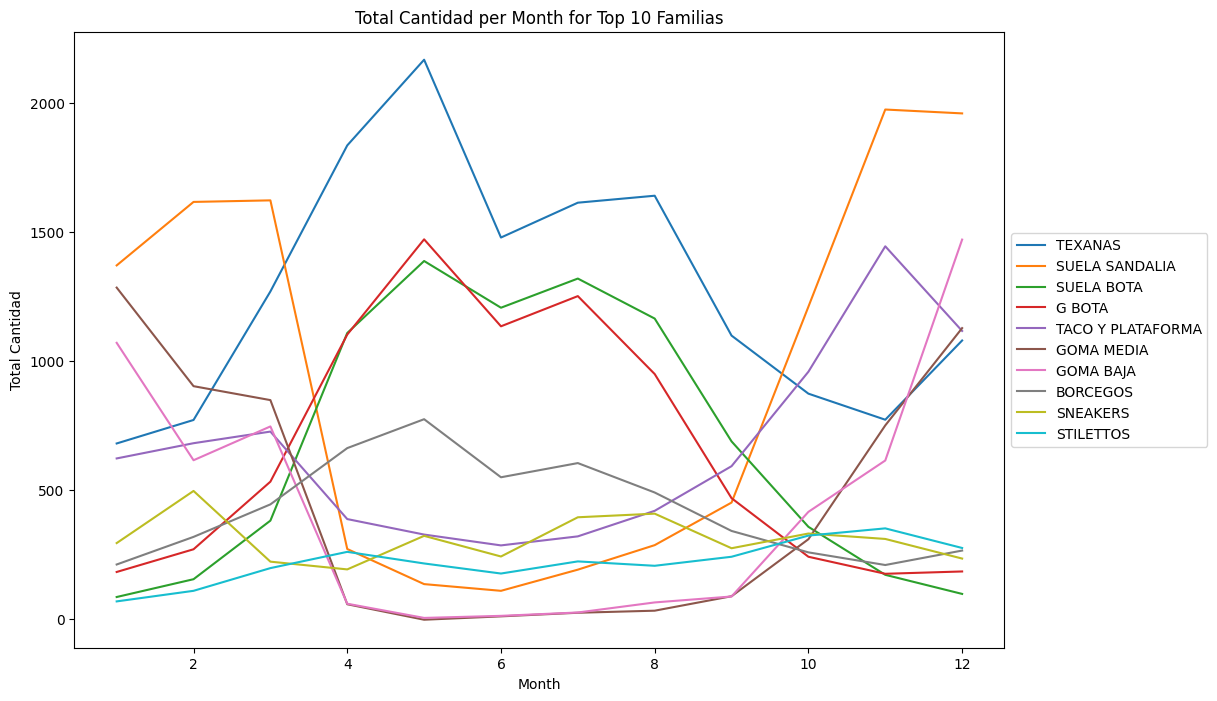

In [ ]:
# Filter the DataFrame for the top 10 families
df_filtered = df[df['Familia'].isin(top_10_familias)].copy()

# Calculate total 'Cantidad' for each 'Familia'
familia_cantidad = df.groupby('Familia')['Cantidad'].sum().sort_values(ascending=False).head(10)

# Get the top 10 families
top_10_familias = familia_cantidad.index.tolist()

# Filter the DataFrame for the top 10 families
df_filtered = df[df['Familia'].isin(top_10_familias)].copy()

# Convert 'Fecha' to datetime with the correct format
df_filtered['Fecha'] = pd.to_datetime(df_filtered['Fecha'], format='%d/%m/%Y', errors='coerce')

# Extract month from 'Fecha'
df_filtered['Month'] = df_filtered['Fecha'].dt.month

# Group by month and family, then sum 'Cantidad'
monthly_sales = df_filtered.groupby(['Month', 'Familia'])['Cantidad'].sum().reset_index()

# Pivot the data for plotting
monthly_sales_pivot = monthly_sales.pivot(index='Month', columns='Familia', values='Cantidad')

# Create the plot
plt.figure(figsize=(12, 8))
for familia in top_10_familias:
  plt.plot(monthly_sales_pivot.index, monthly_sales_pivot[familia], label=familia)

plt.xlabel("Month")
plt.ylabel("Total Cantidad")
plt.title("Total Cantidad per Month for Top 10 Familias")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5)) # Move legend outside the plot
plt.show()

Este grafico muestra el top 10 de familias con mas ventas y el total de ventas por mes. Las curvas demuestran que si existen familias de verano y de invierno.

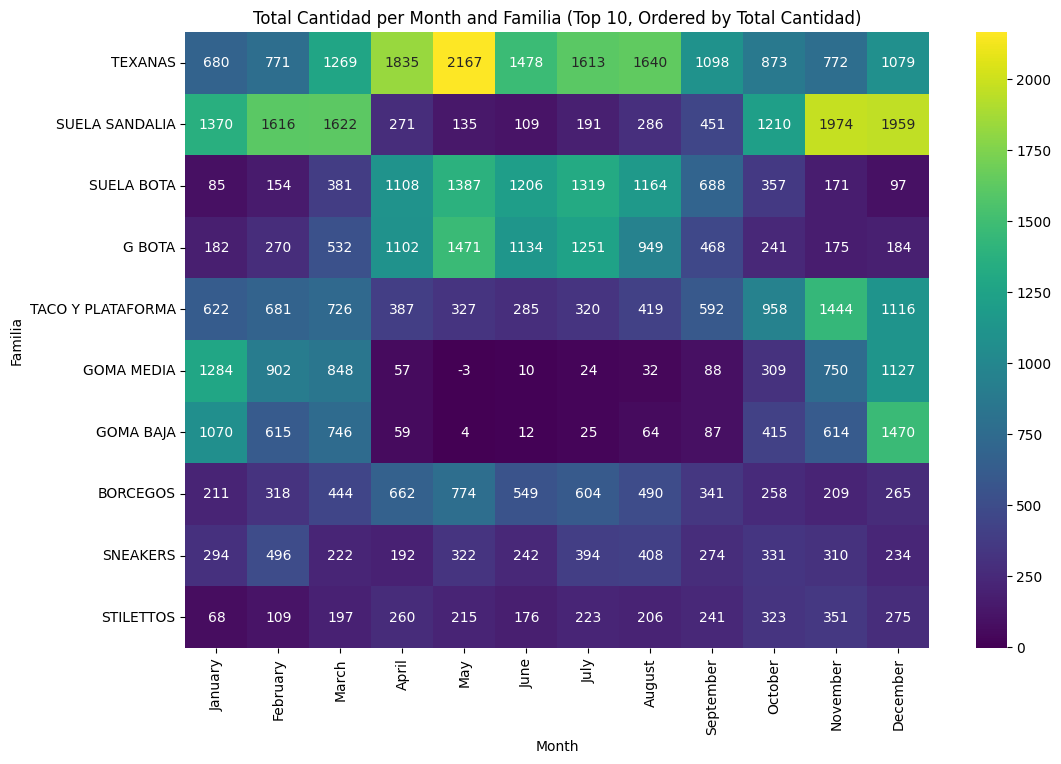

In [ ]:
# Convert 'Fecha' to datetime with the correct format
df['Fecha'] = pd.to_datetime(df['Fecha'], format='%d/%m/%Y', errors='coerce')

# Extract month from 'Fecha'
df['Month'] = df['Fecha'].dt.month

# Group by month and family, then sum 'Cantidad'
monthly_sales = df.groupby(['Month', 'Familia'])['Cantidad'].sum().reset_index()

# Calculate total Cantidad for each Familia
total_cantidad = monthly_sales.groupby('Familia')['Cantidad'].sum().sort_values(ascending=False)

# Get the top 10 families
top_15_familias = total_cantidad.head(10).index

# Filter monthly_sales for top 15 families
monthly_sales_top15 = monthly_sales[monthly_sales['Familia'].isin(top_15_familias)]

# Order families in heatmap data based on total Cantidad
heatmap_data = monthly_sales_top15.pivot(index='Familia', columns='Month', values='Cantidad')

# Reindex heatmap_data based on top 10 families order
heatmap_data = heatmap_data.reindex(top_10_familias)

# Get month names
month_names = pd.to_datetime(heatmap_data.columns, format='%m').strftime('%B')

# Create the heatmap with month names
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='viridis', annot=True, fmt='g', xticklabels=month_names)
plt.xlabel("Month")
plt.ylabel("Familia")
plt.title("Total Cantidad per Month and Familia (Top 10, Ordered by Total Cantidad)")
plt.show()

Este heatmap muestra las ventas por mes, confirmando las familias de verano, las de invierno y las que se venden todo el año.

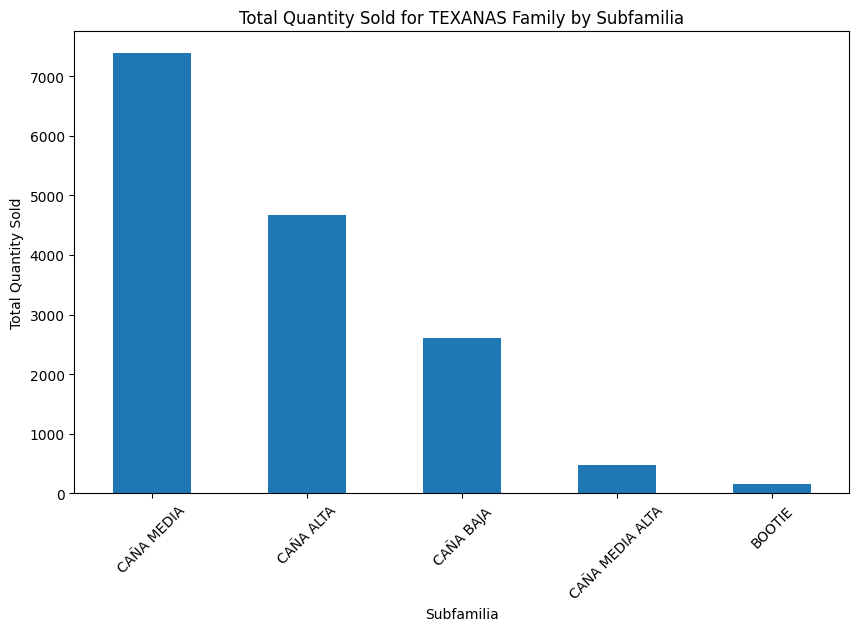

In [ ]:
# Filter for 'TEXANAS' family
texanas_df = df[df['Familia'] == 'TEXANAS']

# Group by 'Subfamilia' and sum 'Cantidad'
color_cantidad = texanas_df.groupby('Subfamilia')['Cantidad'].sum().sort_values(ascending=False)

# Create the plot
ax = color_cantidad.plot(kind='bar', figsize=(10, 6))
plt.title('Total Quantity Sold for TEXANAS Family by Subfamilia')
plt.xlabel('Subfamilia')
plt.ylabel('Total Quantity Sold')
plt.xticks(rotation=45)

plt.show()

Sabiendo que TEXANAS es la familia que tiene mas ventas dentro de la compañia, se abre por subfamilias para encontrar la que tiene mas ventas, siendo Caña media.

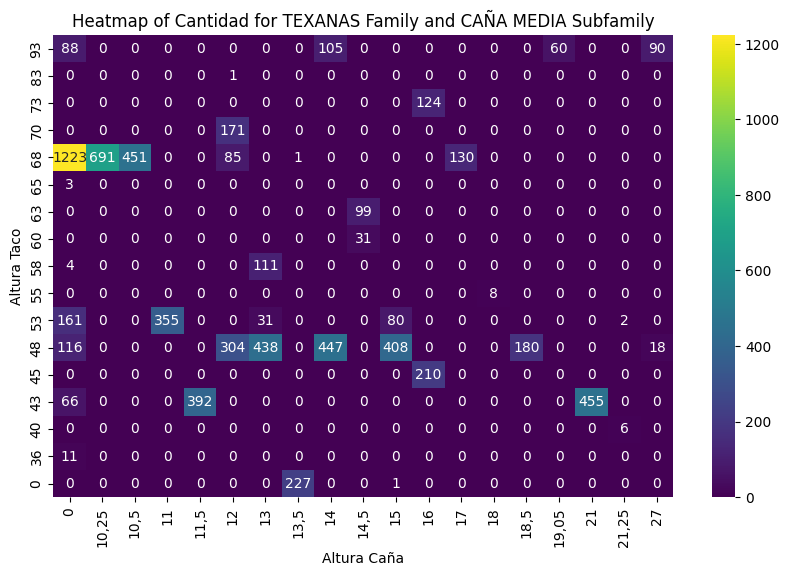

In [ ]:
# Filter for 'TEXANAS' family and 'CAÑA MEDIA' subfamily
filtered_df = df[(df['Familia'] == 'TEXANAS') & (df['Subfamilia'] == 'CAÑA MEDIA')]

# Create a pivot table with 'Altura Taco' as index, 'Altura Caña' as columns,
# 'Cantidad' as values, and 'sum' as the aggregation function
matrix = filtered_df.pivot_table(index='Altura Taco', columns='Altura Caña', values='Cantidad', aggfunc='sum')

# Fill NaN values with 0
matrix = matrix.fillna(0)

# Sort the index (Altura Taco) in descending order
matrix = matrix.sort_index(ascending=False)

# Create the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(matrix, annot=True, fmt='g', cmap='viridis')
plt.title('Heatmap of Cantidad for TEXANAS Family and CAÑA MEDIA Subfamily')
plt.xlabel('Altura Caña')
plt.ylabel('Altura Taco')
plt.show()

Este heatmap mostraria que combinacion de altura caña y altura taco son las ganadoras a la hora de pensar la siguiente TEXANA - Caña media